In [2]:
import pandas as pd
import numpy as np

#### Load Dataset & Some cleaning

In [3]:
df = pd.read_csv('../datasets/bank-full.csv', sep=";")

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
columns_to_use = ['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y']

df = df[columns_to_use]

In [6]:
df["y"] = (df.y == "yes").astype(int)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [9]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [10]:
del df_train["y"]
del df_val["y"]
del df_test["y"]

In [11]:
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

### QUESTION 1: ROC for feature importance

In [12]:
from sklearn.metrics import roc_auc_score

In [13]:
numerical = ["balance","day", "duration", "previous"]

In [14]:
scores = []

for col in numerical:
    tmp = roc_auc_score(y_train, df_train[col])
    if tmp < 0.5:
        tmp = roc_auc_score(y_train, -df_train[col])
    print(f"{col} has score {round(tmp, 3)}")
    scores.append(tmp)

balance has score 0.589
day has score 0.526
duration has score 0.815
previous has score 0.599


### QUESTION 2: TRAINING THE MODEL

In [15]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [16]:
dv = DictVectorizer(sparse=False)

dicts_train = df_train.to_dict(orient="records")
X_train = dv.fit_transform(dicts_train)

In [38]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train, -y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [39]:
dicts_val = df_val.to_dict(orient="records")
X_val = dv.transform(dicts_val)

In [40]:
y_pred = model.predict_proba(X_val)[:,0]

In [41]:
y_pred

array([0.02867543, 0.02234413, 0.02243742, ..., 0.2414899 , 0.00226476,
       0.03642629])

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve

In [42]:
fpr, tpr, threshold = roc_curve(y_val, y_pred)

In [43]:
import matplotlib.pyplot as plt

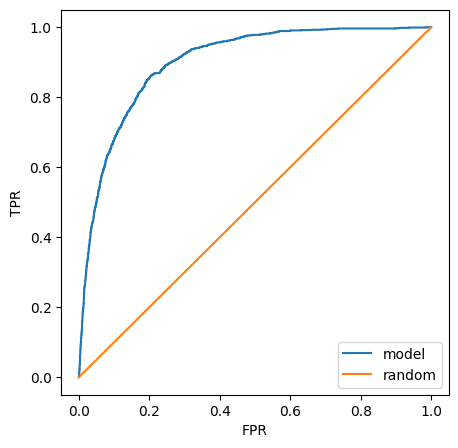

In [44]:
plt.figure(figsize=(5,5))
 
plt.plot(fpr, tpr, label='model')
plt.plot([0,1], [0,1], label='random')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
 
plt.xlabel('FPR')
plt.ylabel('TPR')
 
plt.legend()

In [45]:
roc_auc_score(y_val, y_pred)

np.float64(0.8999705589399016)

In [23]:
y_val

array([0, 0, 0, ..., 0, 0, 0])

### QUESTION 3: PRECISION & RECALL

In [49]:
actual_neg = (y_val == 0)
actual_pos = (y_val == 1)

In [62]:
thresholds = np.linspace(0, 1, 1001)

In [63]:
scores = []
for t in thresholds:
    predict_neg = (y_pred < t)
    predict_pos = (y_pred >= t)

    tp = (predict_pos & actual_pos).sum()
    tn = (predict_neg & actual_neg).sum()
    fp = (predict_pos & actual_neg).sum()
    fn = (predict_neg & actual_pos).sum()

    precision = tp / (tp+fp)
    recall = tp / (tp + fn)

    scores.append((t, precision, recall))


/tmp/ipykernel_16764/3290131084.py:11: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp+fp)


In [64]:
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,precision,recall
0,0.000,0.121433,1.000000
1,0.001,0.121581,1.000000
2,0.002,0.121756,1.000000
3,0.003,0.122244,1.000000
4,0.004,0.123067,1.000000
...,...,...,...
996,0.996,0.555556,0.004554
997,0.997,0.428571,0.002732
998,0.998,0.333333,0.001821
999,0.999,0.200000,0.000911


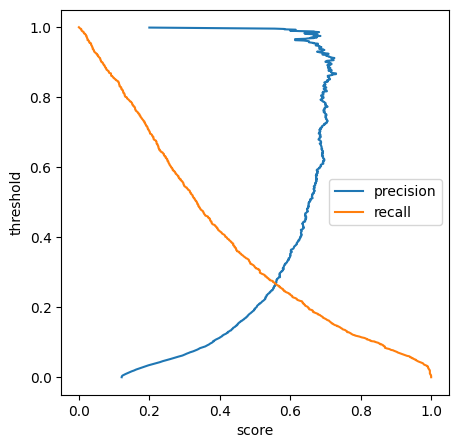

In [65]:
plt.figure(figsize=(5,5))
 
plt.plot(df_scores.precision, df_scores.threshold, label='precision')
plt.plot(df_scores.recall, df_scores.threshold, label='recall')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
 
plt.xlabel('score')
plt.ylabel('threshold')
 
plt.legend()

In [68]:
df_scores[df_scores.threshold == 0.265]

,threshold,precision,recall
265,0.265,0.557466,0.56102


### QUESTION 4: F1 Score

In [69]:
thresholds = np.linspace(0, 1, 101)

In [70]:
scores = []
for t in thresholds:
    predict_neg = (y_pred < t)
    predict_pos = (y_pred >= t)

    tp = (predict_pos & actual_pos).sum()
    tn = (predict_neg & actual_neg).sum()
    fp = (predict_pos & actual_neg).sum()
    fn = (predict_neg & actual_pos).sum()

    precision = tp / (tp+fp)
    recall = tp / (tp + fn)

    f1 = (2 * precision * recall) / (precision + recall)

    scores.append((t, f1, precision, recall))


/tmp/ipykernel_16764/1371390646.py:11: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp+fp)


In [72]:
columns = ['threshold', 'f1', 'precision', 'recall']
df_f1 = pd.DataFrame(scores, columns=columns)
df_f1

,threshold,f1,precision,recall
0,0.00,0.216568,0.121433,1.000000
1,0.01,0.236771,0.134349,0.996357
2,0.02,0.272841,0.158085,0.995446
3,0.03,0.311748,0.184971,0.990893
4,0.04,0.357810,0.219044,0.976321
...,...,...,...,...
96,0.96,0.055798,0.653061,0.029144
97,0.97,0.044014,0.657895,0.022769
98,0.98,0.035461,0.666667,0.018215
99,0.99,0.016173,0.600000,0.008197


In [76]:
df_f1[(df_f1.f1 == df_f1.f1.max())]

,threshold,f1,precision,recall
22,0.22,0.569763,0.524942,0.622951


### QUESTION 5: 5 Fold CV

In [77]:
from sklearn.model_selection import KFold

In [78]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)

In [80]:
y_full_train = df_full_train.y.values

In [81]:
del df_full_train["y"]

In [85]:
y_full_train = (y_full_train == 0).astype(int)

In [99]:
def train_model(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [87]:
def predict(df, dv, model):
    dicts = df.to_dict(orient="records")
    X_predict = dv.fit_transform(dicts)
    y_pred = model.predict_proba(X_predict)[:,1]

    return y_pred

In [97]:
scores = []
for train_index, val_index in cv.split(df_full_train):
    df_train = df_full_train.iloc[train_index]
    df_val = df_full_train.iloc[val_index]

    y_train = y_full_train[train_index]
    y_val = y_full_train[val_index]

    dv, model = train_model(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [98]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.005


In [100]:
C = [0.000001, 0.001, 1]

for c in C:
    scores = []
    for train_index, val_index in cv.split(df_full_train):
        df_train = df_full_train.iloc[train_index]
        df_val = df_full_train.iloc[val_index]

        y_train = y_full_train[train_index]
        y_val = y_full_train[val_index]

        dv, model = train_model(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.701 +- 0.009
0.861 +- 0.007
0.906 +- 0.005
